## Imports

In [4]:
# %matplotlib inline
import pickle
import urllib
import time
import feedparser
import itertools
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.misc
from tqdm import tqdm
import time
from IPython import display

## Load in data

In [48]:
# Category of papers
category = '../../data/astro-ph'

# Metadata
entries = pickle.load(open(category + '_entries.pkl', 'rb'))
author_ind = pickle.load( open(category + '_author_ind.pkl', 'rb'))

# List of edges in train/test graphs
train_adj_list = pickle.load(open(category + '_train_adj_list.pkl', 'rb'))
test_adj_list = pickle.load(open(category + '_test_adj_list.pkl', 'rb'))

# List of edges with year added in train/test graphs
train_adj_list_w_year = pickle.load( open( category + '_train_adj_list_with_year.pkl'))
test_adj_list_w_year = pickle.load( open( category + '_test_adj_list_with_year.pkl'))

# Number of authors
num_authors = len(author_ind)

# List of author ids
authors = range(num_authors)

# Edges
pos_edges = set([(min(a1, a2), max(a1, a2)) for (a1, a2) in \
                 itertools.combinations(authors, 2)]) - set(train_adj_list)
pred_edges = set(test_adj_list) - set(train_adj_list)

# Years in the training set
train_years = sorted(list(set(map(lambda x : x[2], train_adj_list_w_year))))

# Years in the testing set
test_years = sorted(list(set(map(lambda x : x[2], test_adj_list_w_year))))

# All possible edges
possible_edges = list(itertools.combinations(authors, 2))

## Split the edges up by year

In [49]:
edges_by_year = {}
for year in test_years:
    edges_by_year[year] = map(lambda y: y[:2], filter(lambda x : x[2] == year, test_adj_list_w_year))

In [50]:
for year in test_years:
    year, len(edges_by_year[year])

(1996, 1358)

(1997, 2250)

(1998, 5716)

(1999, 4751)

(2000, 4889)

(2001, 2948)

## Train and validation years

In [52]:
years_for_train = train_years
valid_years = test_years[-2:]
'train years', years_for_train, 'validation years', valid_years

('train years', [1996, 1997, 1998, 1999], 'validation years', [2000, 2001])

## Build the set of edges in the training set

In [53]:
train = set()
for year in years_for_train:
    train = train.union(set(edges_by_year[year]))
n_train = len(train)
n_train

14075

## Label all edges as 1 for edge and 0 for no edge

In [54]:
targets = map(lambda x : int(x in train), possible_edges)
zipped_train_input = zip(possible_edges, targets)

In [55]:
o_minus = filter(lambda x : x[1] == 0, zipped_train_input)
o_plus = filter(lambda x : x[1] == 1, zipped_train_input)
n_plus = len(o_plus) 
n_min = len(o_minus)

## Validation set of new edges added

In [58]:
valid = set()
for year in valid_years:
    valid = valid.union(set(edges_by_year[year]))
n_valid = len(valid)
n_valid

7837

## The set of labled edges to be predicted

In [59]:
potential_new_edges = set(map(lambda  y : y[0], filter(lambda x: x[1] == 0, zipped_train_input)))
zipped_valid_input = map(lambda x : (x, 1) if x in valid else (x,0), potential_new_edges)
valid_no_edges = filter(lambda x: x[1] == 0, zipped_valid_input)
valid_yes_edges = filter(lambda x: x[1] == 1, zipped_valid_input)

## Matrix Factorization

#### Sigmoid Link, Log Loss, No extrinsic features

EPOCH 6
Avg Train Loss: 1.73537753277
Avg Validation Loss: 1.73396906377
Avg Score for missing edges: 2.20769518337 Avg Score for added edges: 2.46883084293
Median Score for missing edges: 2.18592424567 Media Score for added edges: 2.43032406541
Avg Difference: 0.261135659565
Median Difference: 0.244399819742
Accuracy on Top 7837 : 0.0853642975628


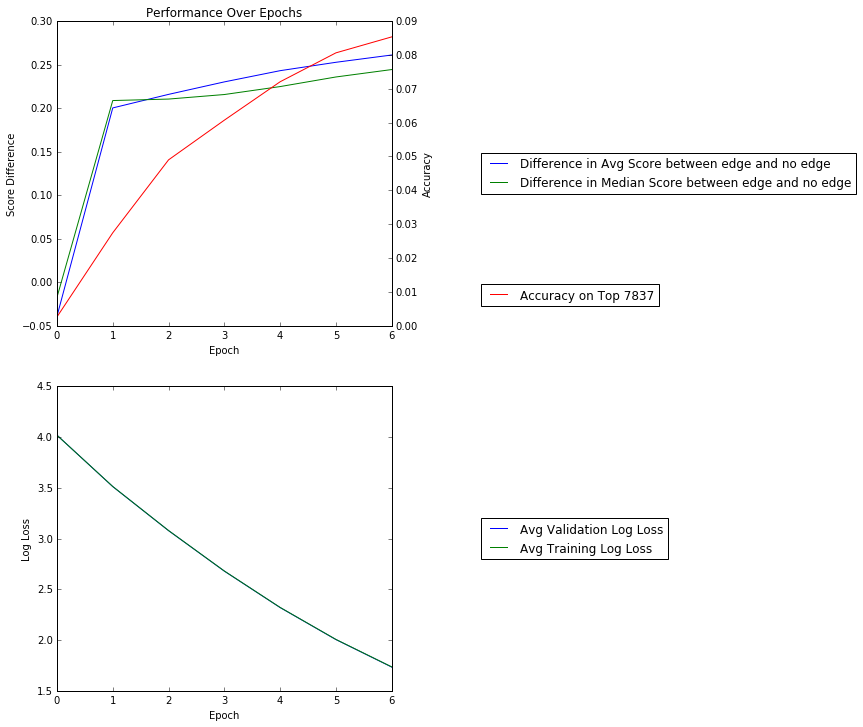

 35%|███▍      | 311/900 [02:56<05:17,  1.85it/s]

In [ ]:
VERBOSE = True
ADD_LOG = True
PLOT = True
n_neg = 10000
n_pos = 900

if PLOT:
    %matplotlib inline

gammaU = 1e-3 # Learning rate for latent feature vectors
gammaB = 1e-3 # Learning rate for node biases
# lambdaU = 1e-1 # regularization parameter for latent feature vecotrs
TOP_K = n_valid # K to use for top k accuracy
N_EPOCH = 25 # Number of epochs to train
link = lambda x : x # the link function mapping score to prediction
link_name = 'identity'
loss = lambda (p, t): (p - t)**2 # loss function takes in prediction and target and returns loss
loss_name = 'squared'
score = lambda i, j, ip, jp: np.dot(U[i], U[j]) + B[i] + B[j] -(np.dot(U[ip], U[jp]) + B[ip] + B[jp]) # Takes in two nodes and scores their probability of an edge
score1 = lambda i, j : np.dot(U[i], U[j]) + B[i] + B[j]
k = 25
# k_vals = [5, 10, 25, 50, 75, 100] # Number of latent features
lambdaU_vals = [1e-2]

results = {}

###################################################################################################


for lambdaU in lambdaU_vals:
    U = np.random.rand(num_authors,k) # latent feature matrix
    B = np.random.rand(num_authors) # Biases

    # Holding the train/validation losses
    train_losses = []
    valid_losses = []

    # Holds the average/medians prediction score for edges being added and not added
    no_avgs = []
    no_meds = []
    yes_avgs = []
    yes_meds = []

    # Differences between yes_avgs and no_avgs, yes_meds and no_meds
    diff_avgs = []
    diff_meds = []

    # Accuracy on TOP_K
    topk_acc = []


    def predict(vals):
        '''
            Give the zipped input, returned the prediction and target value in a 
            list of tuples

            (pred, targ)
        '''
        return map(lambda ((i,j), t) : (link(score1(i, j)), t), vals)

    def calc_loss(vals):
        '''
            Return the loss for the current state 
        '''
        # Regularizer
        reg_term = lambdaU * np.linalg.norm(U, ord='fro')

        # Make predictions
        preds = predict(vals)

        # Calculate loss with regularization
        loss_val = np.mean(map(loss, preds)) + reg_term

        if ADD_LOG:
            loss_val = np.log(loss_val)
        return loss_val

    def top_acc(vals):
        '''
            Determine our TOP_K rated edges and see if they are in the set
            of edges that were added in the validations et
        '''
        predictions = predict(vals)

        # Sort predictions 
        sorted_scores = sorted(predictions, key= lambda  x: x[0], reverse=True)

        # Sett how many of the top predictions have an edge
        return len(filter(lambda x : x[1] == 1, sorted_scores[:TOP_K])) / float(TOP_K)

    def print_status(epoch, verbose = VERBOSE):
        '''
            Prints the current status of the SGD operation
        '''
        if VERBOSE: print 'EPOCH', epoch

        train_losses.append(calc_loss(zipped_train_input))
        if VERBOSE: print 'Avg Train Loss:',train_losses[epoch]

        valid_losses.append(calc_loss(zipped_valid_input))
        if VERBOSE: print 'Avg Validation Loss:', valid_losses[epoch]

        no_preds =  map(lambda x : x[0], predict(valid_no_edges))
        no_avgs.append(np.mean(no_preds))
        no_meds.append(np.median(no_preds))

        yes_preds = map(lambda x : x[0],predict(valid_yes_edges))
        yes_avgs.append(np.mean(yes_preds))
        yes_meds.append(np.median(yes_preds))
        if VERBOSE: print 'Avg Score for missing edges:', no_avgs[epoch], 'Avg Score for added edges:', yes_avgs[epoch]
        if VERBOSE: print 'Median Score for missing edges:', no_meds[epoch], 'Media Score for added edges:', yes_meds[epoch]

        diff_avgs.append(yes_avgs[epoch] - no_avgs[epoch])
        if VERBOSE: print 'Avg Difference:', diff_avgs[epoch]

        diff_meds.append(yes_meds[epoch] - no_meds[epoch])
        if VERBOSE: print 'Median Difference:', diff_meds[epoch]

        topk_acc.append(top_acc(zipped_valid_input))
        if VERBOSE: print 'Accuracy on Top', TOP_K, ':', topk_acc[epoch]

    def plot_results(epoch):
        '''
            Plots the results vs the epochs
        '''
        plt.clf()
        fig, ax = plt.subplots(2,1, figsize = (6,12))

        # PLot score differential
        _ = ax[0].plot(range(epoch + 1), diff_avgs, label = 'Difference in Avg Score between edge and no edge')
        _ = ax[0].plot(range(epoch + 1), diff_meds, label = 'Difference in Median Score between edge and no edge')
        _ = ax[0].set_title('Performance Over Epochs')
        _ = ax[0].set_xlabel('Epoch')
        _ = ax[0].set_ylabel('Score Difference')

        # On same plot plot accuracy on top k
        ax2 = ax[0].twinx()
        _ = ax2.plot(range(epoch + 1), topk_acc, 'r', label = 'Accuracy on Top %s' % TOP_K)
        _ = ax2.set_ylabel('Accuracy')
        lg1 = ax2.legend(loc='center left', bbox_to_anchor=(1.25, 0.1))
        lg2 = ax[0].legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

        if ADD_LOG: 
            ext = "Log "
        else:
            ext = ""

        # On second plot plot loss
        _ = ax[1].plot(range(epoch + 1), valid_losses, label = 'Avg Validation %sLoss' % ext)
        _ = ax[1].plot(range(epoch + 1), train_losses, label = 'Avg Training %sLoss' % ext)
        _ = ax[1].set_xlabel('Epoch')
        _ = ax[1].set_ylabel("%sLoss" % ext)
        lg3 = ax[1].legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
        
        plt.savefig('plots/MF_LINK_%s_LOSS_%s_K_%d_LAMBDAU_%f_RANKING_TEST.png' % (link_name, loss_name, k, lambdaU), bbox_extra_artists=(lg1,lg2,lg3), bbox_inches='tight')
        



    print_status(0)

    # SGD
    for epoch in range(1, N_EPOCH+1):

        # Shuffle the training values
        np.random.shuffle(o_plus)
        np.random.shuffle(o_minus)
    
        # Iterate through possible edges and update parameters
        to_iter = range(n_pos)
        if VERBOSE:
            to_iter = tqdm(to_iter)

        for _ in to_iter:
            for _ in range(n_neg):
                (i,j), _  = o_plus[np.random.randint(n_plus)]
                (ip,jp), _  = o_minus[np.random.randint(n_min)]
                
                eij = score(i,j, ip, jp) - 1.
                U[i] -= gammaU*(eij*U[j] + lambdaU*U[i])
                U[j] -= gammaU*(eij*U[i] + lambdaU*U[j])
                B[i] -= gammaU*eij
                B[j] -= gammaU*eij
                
                U[ip] -= gammaU*(-eij*U[jp] + lambdaU*U[ip])
                U[jp] -= gammaU*(-eij*U[ip] + lambdaU*U[jp])
                B[ip] -= gammaU*-eij
                B[jp] -= gammaU*-eij

        if VERBOSE and PLOT: 
            # Clear the display
            display.clear_output(wait=True)
            time.sleep(1)

        # Print out the results of the epoch
        print_status(epoch)
        
        if PLOT:
            # Plot and saves results
            plot_results(epoch)

        if VERBOSE and PLOT: 
            # Display plot
            display.display(plt.gcf())
    
    results[lambdaU] = {}
    
    results[lambdaU]['U'] = U.copy()
    results[lambdaU]['B'] = B.copy()
    results[lambdaU]['train_losses'] = train_losses[:]
    results[lambdaU]['valid_losses'] = valid_losses[:]
    results[lambdaU]['no_avgs'] = no_avgs[:]
    results[lambdaU]['no_meds'] = no_meds[:]
    results[lambdaU]['yes_avgs'] = yes_avgs[:]
    results[lambdaU]['yes_meds'] = yes_meds[:]
    results[lambdaU]['diff_avgs'] = diff_avgs[:]
    results[lambdaU]['diff_meds'] = diff_meds[:]
    results[lambdaU]['topk_acc'] = topk_acc[:]
    
    
    


In [ ]:
'done'

1